copied the code from exopop_with_ravi.ipynb,

The original exopop.ipynb from Dan Foreman-Mackey, is found at
http://dan.iel.fm/downloads/notebooks/exopop.ipynb, and the 
accompanying blog post is at
http://dan.iel.fm/posts/exopop/

Adapting this notebook to work in the phase space of 
[ insolation , planet radius ] rather than [period , planet radius ]

@author: jcatanza

Tues. Apr 19: @author mshabram
updating population inference. Powerlaw method for Rp and log10 insolation 

Wed. Jun 1: @author mshabram and jcatanza
Developing PyStan population model using functions 


In [1]:
#%%=========================================================
# Intialize
# Had to put __future__ before other imports
from __future__ import division, print_function
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
import os
import requests
import pandas as pd
from cStringIO import StringIO

# The following commands are for use in the notebook environment
# Comment them out if this code is to be run in a python or ipython shell
%matplotlib inline
%config InlineBackend.figure_format = "retina"



//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#%%=========================================================
# This function downloads and caches a dataset from the exoplanet archive
# into a pandas frame
def get_catalog(name, basepath="data"):
    fn = os.path.join(basepath, "{0}.h5".format(name))
    if os.path.exists(fn):
        return pd.read_hdf(fn, name)
    if not os.path.exists(basepath):
        os.makedirs(basepath)
    print("Downloading {0}...".format(name))
    url = ("http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/"
           "nph-nstedAPI?table={0}&select=*").format(name)
    r = requests.get(url)
    if r.status_code != requests.codes.ok:
        r.raise_for_status()
    fh = StringIO(r.content)
    df = pd.read_csv(fh)
    df.to_hdf(fn, name, format="t")
    return df
    


In [3]:
#%%=========================================================
# Get the stellar catalog and make selection cuts   
import numpy as np

#!!!!! Q1-Q17 DR 24 (9.2 pipeline)
stlr = get_catalog("q1_q17_dr24_stellar")

#!!!!! Q1-Q16 (9.1 pipeline)
# stlr = get_catalog("q1_q16_stellar")

# !!!!! Select G dwarfs.
# m = (5300 <= stlr.teff) & (stlr.teff <= 6000)

# !!!!! Select K dwarfs.
m = (3900 <= stlr.teff) & (stlr.teff <= 5300)

# !!!!! Select M dwarfs.
# m = (2400 <= stlr.teff) & (stlr.teff <= 3900)

# stellar radius cut
#m &= stlr.radius <= 1.15

# Only include stars with sufficient data coverage:

# Minimum dataspan of 2 years
m &= stlr.dataspan > 365.25*2.

# Minimum dutycycle of 1/2
m &= stlr.dutycycle > 0.50

# Minimum data coverage of 2 years
m &= stlr.dutycycle*stlr.dataspan > 365.25*2.

# minimum rms cdpp at 7.5 hour pulse
#m &= stlr.rrmscdpp07p5 <= 1000.

# Only select stars with mass estimates.
m &= np.isfinite(stlr.mass)

# put selected data into pandas data frame
base_stlr = pd.DataFrame(stlr)
stlr = pd.DataFrame(stlr[m])

print("Selected {0} targets after cuts".format(len(stlr)))


Selected 40685 targets after cuts


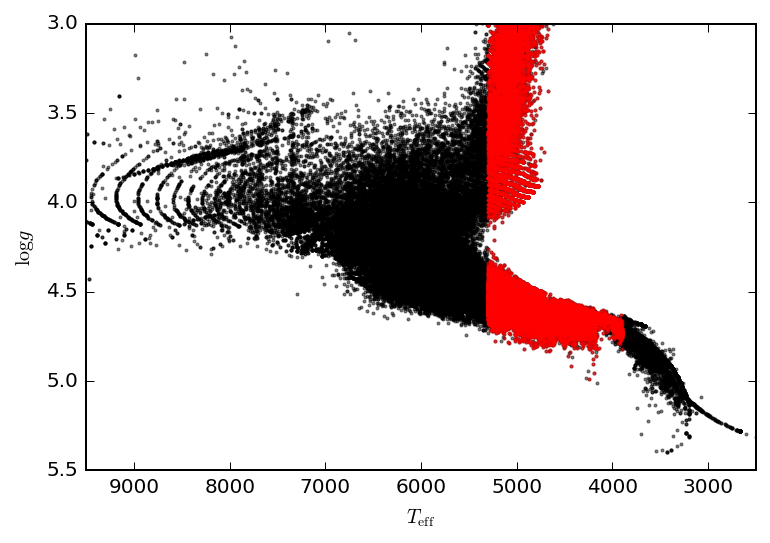

In [4]:
#%%=========================================================
# Plot an HR diagram of the selected targets
import matplotlib.pyplot as pl

pl.plot(base_stlr.teff, base_stlr.logg, ".k", ms=3, alpha=0.5)
pl.plot(stlr.teff, stlr.logg, ".r", ms=3, alpha=0.5)
pl.xlim(9500, 2500)
pl.ylim(5.5, 3)
pl.ylabel("$\log g$");
pl.xlabel("$T_\mathrm{eff}$");


In [5]:
#%%=========================================================

# !!!!! Get the planet catalog and make selection cuts 

# !!!!! Q1-Q17 DR24 (9.2 pipeline)
kois = get_catalog("q1_q17_dr24_koi")

# !!!!! Q1-Q16 planet catalog (9.1 pipeline)
# kois = get_catalog("q1_q16_koi")

# Set insolation and planet radius ranges
# period_rng = (20, 320)
rp_rng = (0.75, 2.5)
insolation_rng = (0.2, 20)

# Join on the stellar list.
kois = pd.merge(kois, stlr[["kepid"]], on="kepid", how="inner")

# Only select the KOIs in the relevant part of parameter space.
m = kois.koi_pdisposition == "CANDIDATE"
base_kois = pd.DataFrame(kois[m])

# Select insolation range instead of period range
m &= (insolation_rng[0] <= kois.koi_insol) & (kois.koi_insol <= insolation_rng[1])
# m &= (period_rng[0] <= kois.koi_period) & (kois.koi_period <= period_rng[1])

m &= np.isfinite(kois.koi_prad) & (rp_rng[0] <= kois.koi_prad) & (kois.koi_prad <= rp_rng[1])

# !!!!! Only include PCs with MES > 15 for 9.2 (Q1-Q17 Dr24)
m &= kois.koi_max_mult_ev > 15
# !!!!! Comment out above statement for 9.1 (Q1-Q16) -- Note all max_mult_ev seem to be NaNs anyyway

# Panda data frame for selected kois
kois = pd.DataFrame(kois[m])

print("min insolation = {0} ".format(np.min((kois.koi_insol))))
print("max insolation = {0} ".format(np.max((kois.koi_insol))))
print(kois.koi_insol)


print("min period = {0} ".format(np.min(kois.koi_period)))
print("max period = {0} ".format(np.max(kois.koi_period)))
print("Selected {0} KOIs after cuts".format(len(kois)))


min insolation = 0.34 
max insolation = 19.88 
11      18.25
19       0.75
54       1.02
71       0.94
78      11.89
87       1.41
114     17.37
154      9.48
156     14.91
158      1.17
212     15.58
213      3.38
214      0.34
229     19.18
232     10.58
241     18.81
263     16.30
280      3.29
282      7.76
283      4.04
318      4.38
376      2.79
377     10.96
392     16.75
431     14.22
436      9.45
496     18.25
523      1.28
591      7.21
605      6.12
        ...  
1156    15.07
1170     9.14
1176     2.91
1186     3.53
1187     1.16
1190     7.96
1202    18.58
1203     0.40
1223     8.09
1232    10.07
1274     5.03
1276    14.29
1289     7.96
1302     4.18
1306    10.46
1308     4.01
1341     5.56
1342    14.76
1343     1.91
1347    14.49
1354     9.42
1364     4.28
1379     3.65
1388     3.28
1389     7.81
1405     8.54
1412    16.42
1418    14.78
1444     1.30
1460    15.86
Name: koi_insol, dtype: float64
min period = 5.92365634 
max period = 247.354265 
Selected 117 KOIs

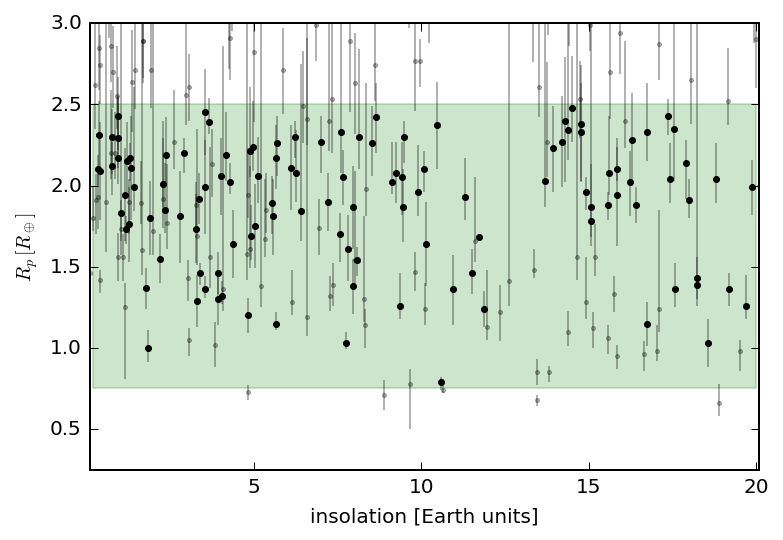

In [6]:
#%%=========================================================
# Plot the measurements with error bars, in insolation-radius phase space
yerr = np.abs(np.array(base_kois[["koi_prad_err2", "koi_prad_err1"]])).T
pl.errorbar(base_kois.koi_insol, base_kois.koi_prad, yerr=yerr, fmt=".k", ms=4,
            capsize=0, alpha=0.3)
pl.plot(kois.koi_insol, kois.koi_prad, ".k", ms=6)
pl.fill_between(insolation_rng, [rp_rng[1], rp_rng[1]], [rp_rng[0], rp_rng[0]], color="g", alpha=0.2)
pl.xlim(insolation_rng + 0.1 * np.array([-1, 1]))
pl.ylim(rp_rng + 0.5 * np.array([-1, 1]))
pl.xlabel("insolation [Earth units]")
pl.ylabel("$R_p \, [R_\oplus]$");


In [7]:
#%%=========================================================
# Completeness model helper functions

from scipy.stats import gamma

def get_duration(period, aor, e):
    """
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param e:      the eccentricity of the orbit
    
    """
    return 0.25 * period * np.sqrt(1 - e**2) / aor

def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ^ (1./3)

def get_delta(k, c=1.0874, s=1.0187):
    """
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
    """
    delta_max = k*k * (c + s*k)
    
    # !!!!! For Q1-Q16 (9.1 pipeline) DFM used a multiplier 0f 0.84 instead of 1.0 in the equation below
    # return 0.84*delta_max
    
    # !!!!! for Q1-Q17 DR24 (9.2 pipeline), use a multiplier of 1 ????? Ask Chris
    return 1.0* delta_max

# 14 pulse durations
cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)

def get_mes(star, period, rp, tau, re=0.009171):
    """
    Estimate the multiple event statistic value for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    
    """
    # Interpolate the RMS CDPP corresponding to the transit duration.
    cdpp = np.array(star[cdpp_cols], dtype=float)
    sigma = np.interp(tau, cdpp_vals, cdpp)

    # Compute the radius ratio and estimate the S/N.
    k = rp * re / star.radius
    snr = get_delta(k) * 1e6 / sigma
    
    # Scale by the estimated number of transits.
    ntrn = star.dataspan * star.dutycycle / period 
    return snr * np.sqrt(ntrn)

# Pre-compute and freeze the gamma function from Equation (5) in
# Burke et al.

# !!!!! Q1-Q16 (9.1 pipeline): DFM used the parameters below
# pgam = gamma(4.65, loc=0., scale=0.98)
# !!!!! But the parameters for FGK are (4.35, 0, 1.05) according to astro-ph 1507.05097 (Christiansen)
# pgam = gamma(4.35, loc=0., scale=1.05)

# !!!!! Parameters for 9.2 pipeline Q1-Q17 DR24 are from Jessie Christiansen
# !!!!! Note that these parameters do not apply to M stars!
pgam = gamma(103.0113, loc=0., scale=0.10583)

# mesthres_cols are column names for the 14 pulse durations
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]

# pulse_durations_obs are the 14 pulse durations
pulse_durations_obs = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)
def get_pdet(star, aor, period, rp, e):
    """
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the orbital eccentricity
    
    """
    # mest is the interpolated MES threshold corresponding to the transit duration
    # tau is the pulse duration
    # pulse_durations_obs are the 14 pulse durations
    # np.array(star[mesthres_cols],dtype=float) are the coresponding MES thresholds
    tau = get_duration(period, aor, e) * 24.
    mes = get_mes(star, period, rp, tau)
    mest = np.interp(tau, pulse_durations_obs,
                     np.array(star[mesthres_cols],
                              dtype=float))
    x = mes - 4.1 - (mest - 7.1)
    
    # !!!!! DFM originally used no multiplier in the equation below;
    # The multiplier of 0.78442 must be a 'plateau factor' from Jessie, for 9.2
    # for the 9.2 Q1-Q17 DR24 data, provided by Jessie
    return 0.78442*pgam.cdf(x)

    # !!!!! For the 9.1 data
    # return pgam.cdf(x)

def get_pwin(star, period):
    """
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
    """
    M = star.dataspan / period
    f = star.dutycycle
    omf = 1.0 - f
    pw = 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2)
    msk = (pw >= 0.0) * (M >= 2.0)
    return pw * msk

def get_pgeom(aor, e):
    """
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

    """
    return 1. / (aor * (1 - e*e)) * (aor > 1.0)


    


 


In [8]:
#================================================================================================
#%% This cell contains functions and code for calculating completeness in the
#       phase space of [ insolation , planet radius ] 
    
def get_completeness(star, period, rp, e, with_geom=True):
    """
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties
    :param period:    the period in days
    :param rp:        the planet radius in Earth radii
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability?
    
    """
    aor = get_a(period, star.mass) / star.radius
    pdet = get_pdet(star, aor, period, rp, e)
    pwin = get_pwin(star, period)
    if not with_geom:
        return pdet * pwin
    pgeom = get_pgeom(aor, e)
    return pdet * pwin * pgeom

# Construct grid for planet radius
rp2 = np.linspace(rp_rng[0], rp_rng[1], 61)

# Construct grid for insolation
insolation_rng = (0.2, 22)
insolation = np.linspace(insolation_rng[0], insolation_rng[1], 57)
insolation_grid, rp_grid2 = np.meshgrid(insolation, rp2, indexing="ij")
   
    
def get_completeness_from_insolation(star, insolation_grid, rp_grid2, e, with_geom=True):
    
    # compute the periods corresponding to an insolation grid
    insolation = insolation_grid
    period_grid = get_period_from_insolation( star , insolation )
    
    # completeness 
    completeness = get_completeness(star, period_grid, rp_grid2, e, with_geom=True)
    
    return completeness
    

# Add a function to compute insolation on the period grid, for a given star 
def get_insolation_from_period( star , period ):
    
    # Get needed stellar parameters
    teffStar = star.teff
    teffSun = 5777
    rStar = star.radius
    mStar = star.mass
    
    # Semimajor axis of planet in AU
    aPlanet = mStar**(1.0/3.0) * (period/365.25)**(2.0/3.0) 
    
    # Compute insolation
    insolation = (teffStar/teffSun)**4*(rStar/1)**2*(1/aPlanet)**2
    
    return insolation
    
def get_period_from_insolation( star , insolation ):
    
    # Get needed stellar parameters
    teffStar = star.teff
    teffSun = 5777
    rStar = star.radius
    mStar = star.mass
    
    # Get semimajor axis from star properties and insolation, using
    # insolation = ( teffStar / teffSun )**4 * ( rStar / 1)**2 * ( 1 / aPlanet )**2
    aPlanet = ( ( teffStar / teffSun )**4 * ( rStar / 1)**2 / insolation )**(0.5)
    
    # Get orbit period in days from semimajor axis of planet in AU and start properties, using
    # aPlanet = mStar**(1.0/3.0) * (period/365.25)**(2.0/3.0)
    period = 365.25 * ( aPlanet/( mStar**(1.0/3.0) ) )**(3.0/2.0)
    
    return period



In [9]:
#%%==============================================================================================
# Test: compute completeness grid in [ insolation , planet radius ] 
# phase space for the first star in the catalog
new_completeness_grid_single_star = get_completeness_from_insolation(stlr.iloc[0], insolation_grid, rp_grid2, 0.0, with_geom=True)

# Marginalize detection contours over all selected targets
# including the geometric factor. This takes a few minutes.
new_completeness = np.zeros_like(insolation_grid)
for _, star in stlr.iterrows():
    new_completeness += get_completeness_from_insolation(star, insolation_grid, rp_grid2, 0.0, with_geom=True)


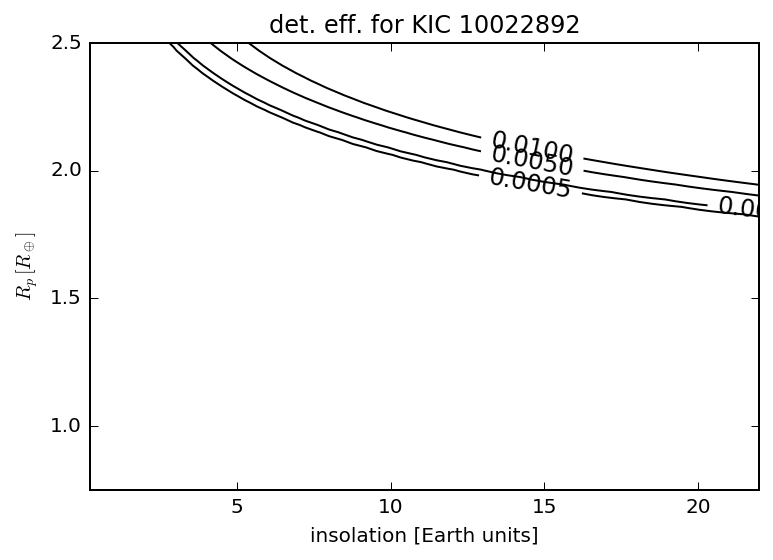

In [10]:
#%%=========================================================
# Reproducing Figure 1 from Burke paper, which is the
# completeness contour (not including geometric effect) for an example target
 
# Repeating for new insolation completeness.  
    
# Choose the first star
# star = stlr[stlr.kepid == 10593626].iloc[0]
# First M star
#star = stlr[stlr.kepid == 10031707].iloc[0]
star = stlr[stlr.kepid == stlr.kepid.iloc[0]].iloc[0]

# Compute the completeness map on a grid.
X, Y = insolation_grid, rp_grid2
Z = get_completeness_from_insolation(star, X, Y, 0.0, with_geom=False)

# Plot with the same contour levels as the figure. Add some contours at low end of completeness.
c = pl.contour(X, Y, Z, [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99], colors="k")
pl.clabel(c, fontsize=12, inline=1, fmt="%.4f") 
pl.xlabel("insolation [Earth units]")
pl.ylabel("$R_p \, [R_\oplus]$")
pl.title("det. eff. for KIC {0}".format(np.min(stlr.kepid.iloc[0])));


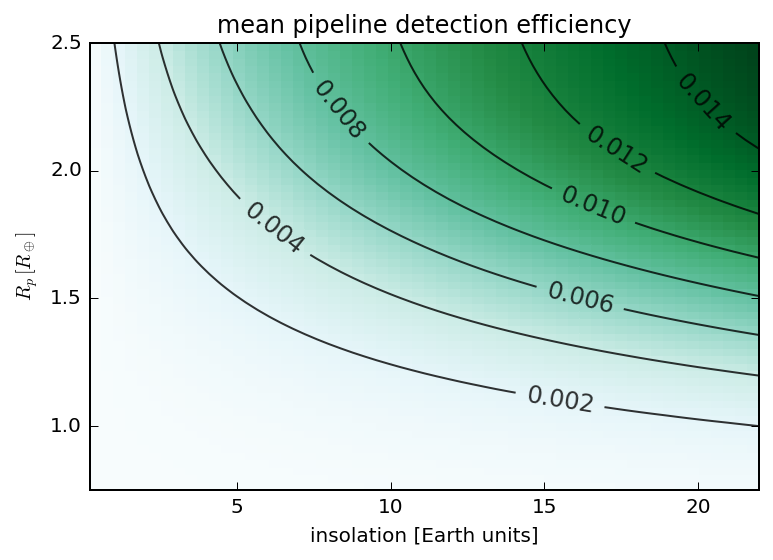

In [11]:
#%%=========================================================
# Plot the average new_completeness contour (radius-insolation)
# Include the geometric effect
pl.pcolor(insolation_grid, rp_grid2, new_completeness, cmap="BuGn")
c = pl.contour(insolation_grid, rp_grid2, new_completeness / len(stlr),
               colors="k", alpha=0.8)
pl.clabel(c, fontsize=12, inline=1, fmt="%.3f")
pl.title("mean pipeline detection efficiency")
pl.xlabel("insolation [Earth units]")
pl.ylabel("$R_p \, [R_\oplus]$");


In [12]:
#%%=========================================================
# Population inference with an independent power law model
# Using modified code above that computes 
# completeness in the phase space of [ insolation , planet radius ], 

# A double power law model for the population.
def population_model_insolation(theta, insolation, rp):
    # Parameters 
    # lnf0 is normalization, 
    # beta is exponent of insolation power law,
    # alpha is exponent of radius power law
    lnf0, beta, alpha = theta
    v = np.exp(lnf0) * np.ones_like(insolation)
    for x, rng, n in zip((insolation, rp),
                         (insolation_rng, rp_rng),
                         (beta, alpha)):
        n1 = n + 1
        v *= x**n*n1 / (rng[1]**n1-rng[0]**n1)
    return v

# The ln-likelihood function given at the top of this post.
# change to insolation from planet catalog

# Insolation and radius for planets in catalog
# koi_periods = np.array(kois.koi_period)
koi_insolation = np.array(kois.koi_insol)
koi_rps = np.array(kois.koi_prad)

# Phase space volume in each bin of [insolation, radius] grid
# Note the bins are not uniformly spaced in insolation
vol = np.diff(insolation_grid, axis=0)[:, :-1] * np.diff(rp_grid2, axis=1)[:-1, :]
def lnlike(theta):
    pop = population_model_insolation(theta, insolation_grid, rp_grid2) * new_completeness
    pop = 0.5 * (pop[:-1, :-1] + pop[1:, 1:])
    norm = np.sum(pop * vol)
    ll = np.sum(np.log(population_model_insolation(theta, koi_insolation, koi_rps))) - norm
    return ll if np.isfinite(ll) else -np.inf

# The ln-probability function is just proportional to the ln-likelihood
# since we're assuming uniform priors.
bounds = [(-5, 5), (-5, 5), (-5, 5)]
def lnprob(theta):
    # Broad uniform priors.
    for t, rng in zip(theta, bounds):
        if not rng[0] < t < rng[1]:
            return -np.inf
    return lnlike(theta)

# The negative ln-likelihood is useful for optimization.
# Optimizers want to *minimize* your function.
def nll(theta):
    ll = lnlike(theta)
    return -ll if np.isfinite(ll) else 1e15



In [13]:
#%%=========================================================
# Maximum likelihood solution by minimizing negative log-likelihood
from scipy.optimize import minimize
# Initial guess for logF, beta, and alpha
theta_0 = np.array([1, 0.66, -1.5])

r = minimize(nll, theta_0, method="L-BFGS-B", bounds=bounds)
print(r)
# r.x is the vector of parameters (logF, beta, and alpha) from the maximum likelihood solution


      fun: 539.23560451435708
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.95807864e-05,   1.25055521e-04,   3.41060513e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 9
   status: 0
  success: True
        x: array([ 0.82470127, -1.25865917, -0.96842818])


In [14]:
#%%=========================================================
# Plot the maximum likelihood solution

# We'll reuse these functions to plot all of our results.

# This function plots the density of samples of a double power law,
# as a function of the x0 input, marginalized over the y input
def make_plot(pop_comp, x0, x, y, ax):
    # pop_comp is a two-dimensional array of completeness values
    # pop_comp.shape is 57(insolation) x 61(radius)  
    # x0 is: bin edges of second variable (radius), for model fitting
    # x is rebinning of x0 into a coarser grid for the plots
    # y is: bin edges of first variable (insolation), for model fitting
    # Mid-bin values of the 2D array pop_comp, along the first dimension -- insolation
    pop = 0.5 * (pop_comp[:, 1:] + pop_comp[:, :-1])
    # on first call, pop is 56 x 61

    # Integrate completeness over the first variable, y, insolation
    # np.diff(y)[None, :, None] is the phase space interval in y
    pop = np.sum(pop * np.diff(y)[None, :, None], axis=1)
    # After above command, pop is 1D, collapsed onto the radius dimension
    
    # Credible regions in x: radius
    # x is used only to get the phase space interval dx in radius for the plot
    # Note: Assumes bin spacing np.diff(x) is uniform
    a, b, c, d, e = np.percentile(pop * np.diff(x)[0], [2.5, 16, 50, 84, 97.5], axis=0)
    # print(c)

    ax.fill_between(x0, a, e, color="k", alpha=0.1, edgecolor="none")
    ax.fill_between(x0, b, d, color="k", alpha=0.3, edgecolor="none")
    # c is the median value of the distribution over 
    ax.plot(x0, c, "k", lw=1)

def plot_results(samples):
    # Loop through the samples and compute the list of population models.
    samples = np.atleast_2d(samples)
    
    # print(samples.shape)
    # print(len(samples))
    # len(samples) is the length of the MCMC chain
    pop = np.empty((len(samples), insolation_grid.shape[0], insolation_grid.shape[1]))
    gamma_earth = np.empty((len(samples)))
    for i, p in enumerate(samples):
        # insolation_grid and rp_grid2 are meshgrids, 57x61
        # print(p)
        # print(rp_grid2.shape)
        # print(insolation_grid.shape)
        # print(i)
        # power law planet density on insolation, radius grid
        pop[i] = population_model_insolation(p, insolation_grid, rp_grid2)
        # planet density at the point corresponding to earth (insolation = 1 and radius = 1)
        gamma_earth[i] = population_model_insolation(p, 1.0, 1.0) * 1.0
        # print(gamma_earth[i])
        
    # Set up 4x4 grid of plots
    fig, axes = pl.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    
    # Histogram of planet radius over a new grid
    # Using a coarser grid for the plot
    dx = 5*(rp2[1] - rp2[0])
    x = np.arange(rp_rng[0], rp_rng[1] + dx, dx)
    n, _ = np.histogram(koi_rps, x)
    
    # Plot the predicted radius distribution against the observed radius distribution
    ax = axes[0, 0]
    
    # Predicted radius distribution
    # rp2 is of length 61
    # nsolation is of length 57
    # pop is 57 x 61 -- so it's insolation x radius
    # new_completeness is 1 x 57 x 61
    make_plot(pop * new_completeness[None, :, :], rp2, x, insolation, ax)
    
    # Observed radius distribution, with Poisson errors
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("# of detected planets")
    
    # Plot the true radius distribution.
    ax = axes[0, 1]
    make_plot(pop, rp2, x, insolation, ax)
    ax.set_xlim(rp_rng[0], rp_rng[1])
    # ax.set_ylim(0, 0.37)
    ax.set_xlabel("$R_p\,[R_\oplus]$")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}R$; $\Delta R = 0.25\,R_\oplus$")
    
    # Histogram of insolation over a new grid.
    # Using a coarser grid for the plot
    dx = 5*(insolation[1] - insolation[0])
    
    x = np.arange(insolation_rng[0], insolation_rng[1] + dx, dx)
    n, _ = np.histogram(koi_insolation, x)
    
    # Plot the predicted insolation distribution against the observed insolation distribution
    ax = axes[1, 0]
    
    # Predicted insolation distribution
    make_plot(np.swapaxes(pop * new_completeness[None, :, :], 1, 2), insolation, x, rp2, ax)
    
    # Observed insolation distribution, with Poisson errors
    ax.errorbar(0.5*(x[:-1]+x[1:]), n, yerr=np.sqrt(n), fmt=".k",
                capsize=0)
    # ax.set_xlim(insolation_rng[0], insolation_rng[1])
    ax.set_xlim(0.5, insolation_rng[1])
    ax.set_ylim(0, 25)
    ax.set_xlabel("insolation, [Earth units]")
    ax.set_ylabel("# of detected planets")
    
    # Plot the true insolation distribution.
    ax = axes[1, 1]
    make_plot(np.swapaxes(pop, 1, 2), insolation, x, rp2, ax)
    ax.set_xlim(insolation_rng[0], insolation_rng[1])
    ax.set_xlabel("insolation, [Earth units]")
    ax.set_ylabel("$\mathrm{d}N / \mathrm{d}I$; $\Delta I = $")
    
    return gamma_earth



[ 0.45484002]


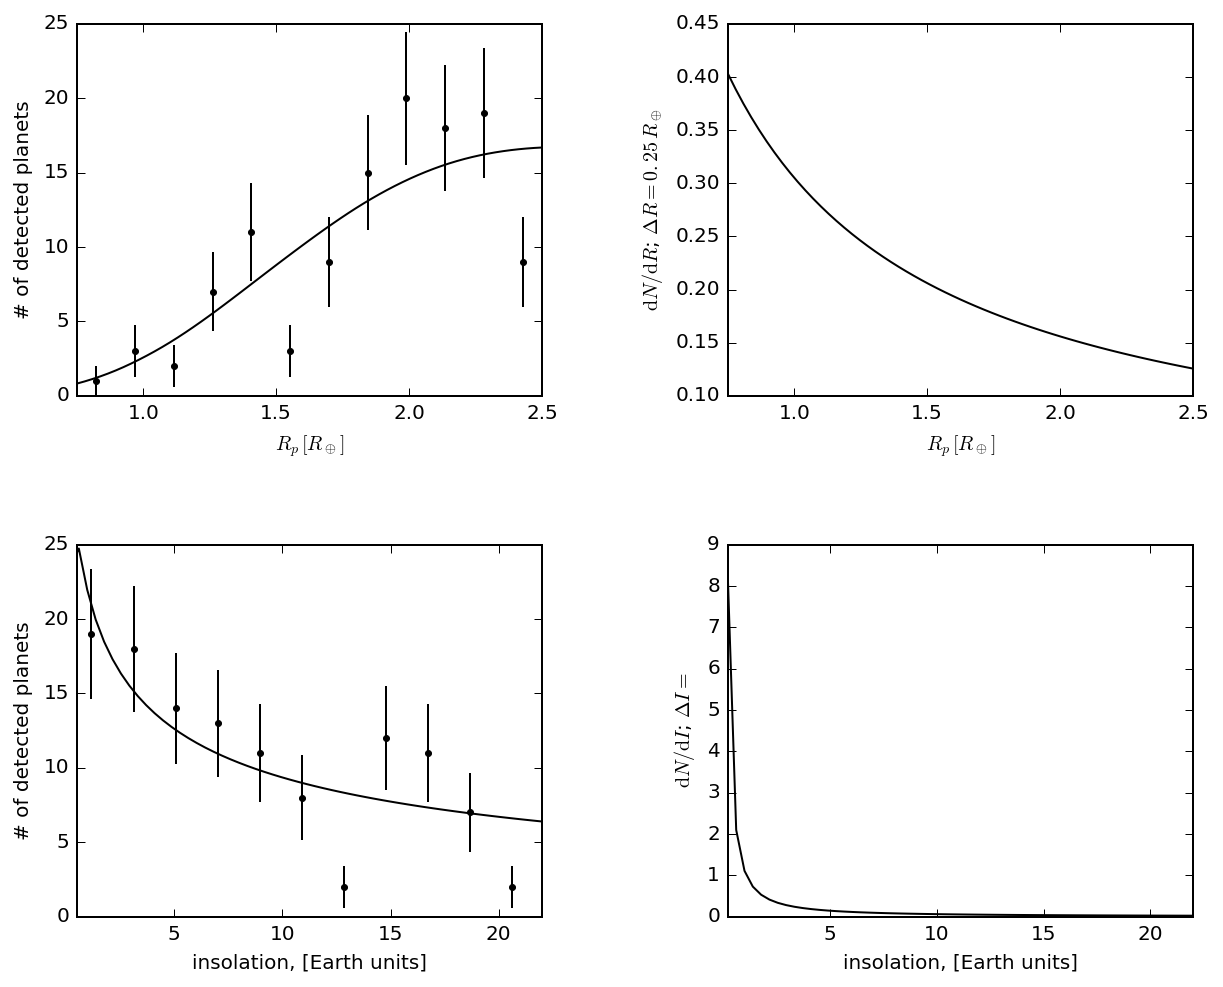

In [15]:
#%%=========================================================

# This line calls all the plotting machinery above, and returns the maximum likelihood value of gamma_earth
# Note that r.x is the set of parameters [ lnf0, beta, alpha ] returned by the maximum likelihood fit
print(plot_results(r.x));

# Or, try your own values for the parameters
# thetaTry = np.array([.01, -1.2, -1.1])
# print(plot_results(thetaTry));

In [16]:
#%%=========================================================
# Sample from the posterior probability distribution for the population parameters using emcee
import emcee

ndim, nwalkers = len(r.x), 16
pos = [r.x + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# Burn in.
pos, _, _ = sampler.run_mcmc(pos, 1000)
sampler.reset()

# Production.
pos, _, _ = sampler.run_mcmc(pos, 4000)



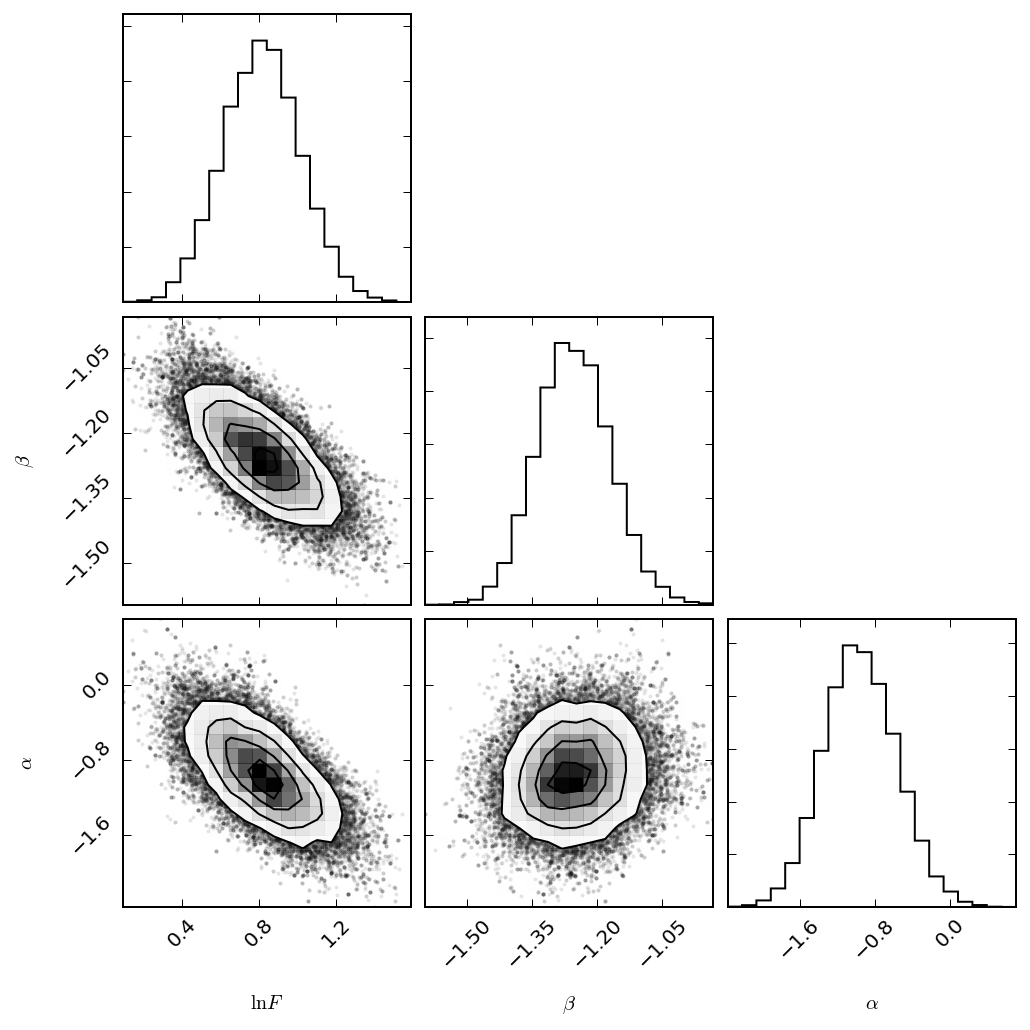

In [17]:
#%%=========================================================
# Triangle plot of PDFs using DFMs corner package
import corner
corner.corner(sampler.flatchain, labels=[r"$\ln F$", r"$\beta$", r"$\alpha$"]);


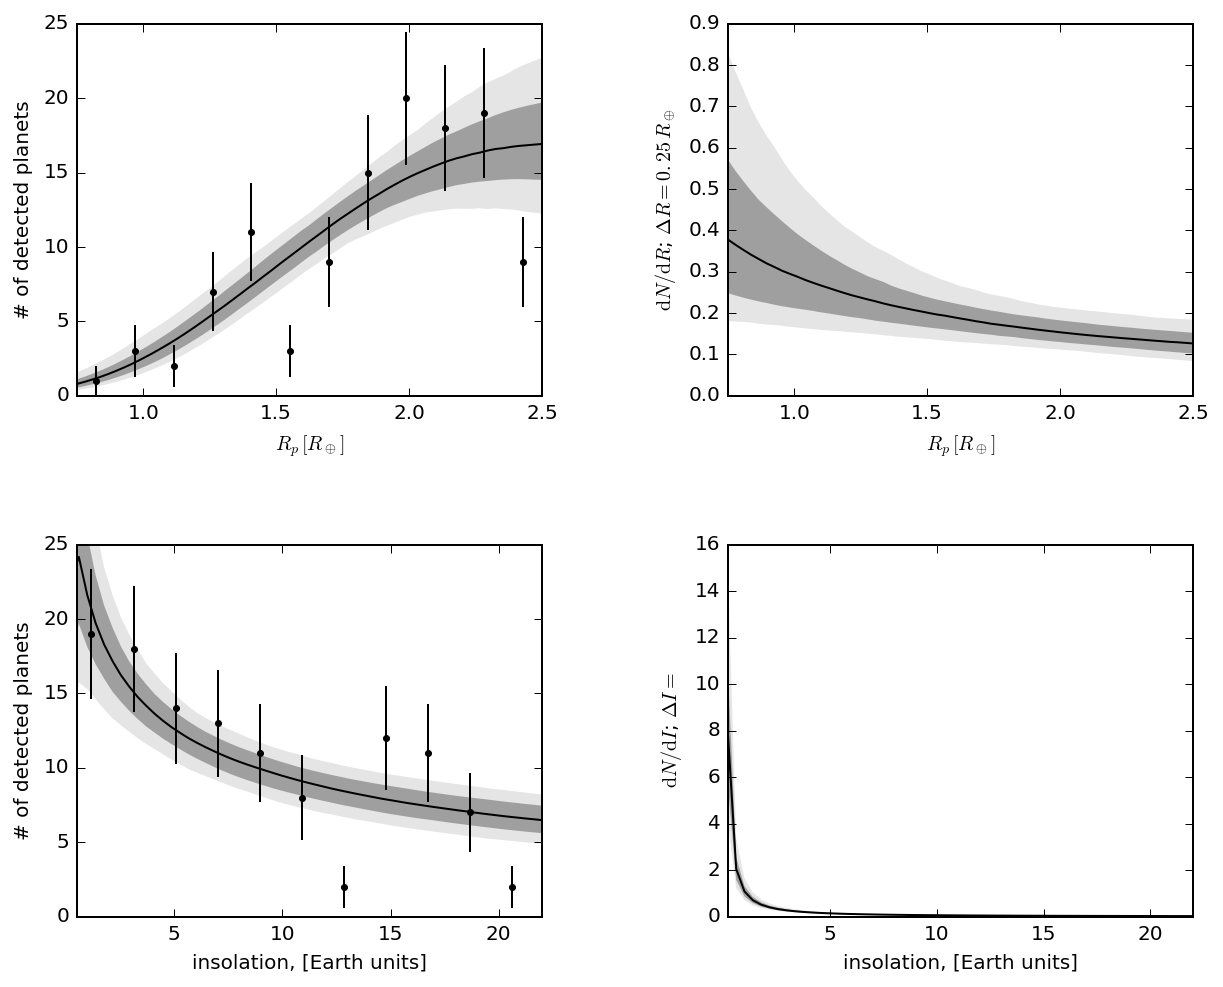

In [18]:
#%%=========================================================
# Plot marginalized posteriors of N and dN/dR
# For Rp, marginalize over P
# For P, marginalize over Rp
# For N, plot also the data and the error bars

# Problem -- plotting all the chains maxes out my PCs memory.    
# Solution -- plot only the last 4000 chains 
gamma_earth = plot_results(sampler.flatchain[60000:63999,:])


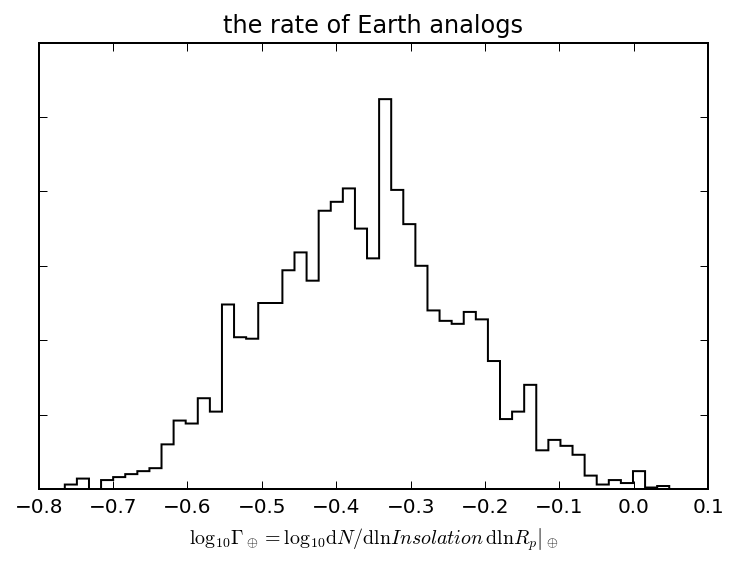

In [19]:
#%%=========================================================
# Plot the PDF of gamma_earth
pl.hist(np.log10(gamma_earth), 50, histtype="step", color="k")
pl.gca().set_yticklabels([])
pl.title("the rate of Earth analogs")
pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln Insolation \, \mathrm{d}\ln R_p \right |_\oplus$");



16, 50, 84 percentile range for integrated gamma = [ 0.36242823  0.47863111  0.62200683] 


<function matplotlib.pyplot.xticks>

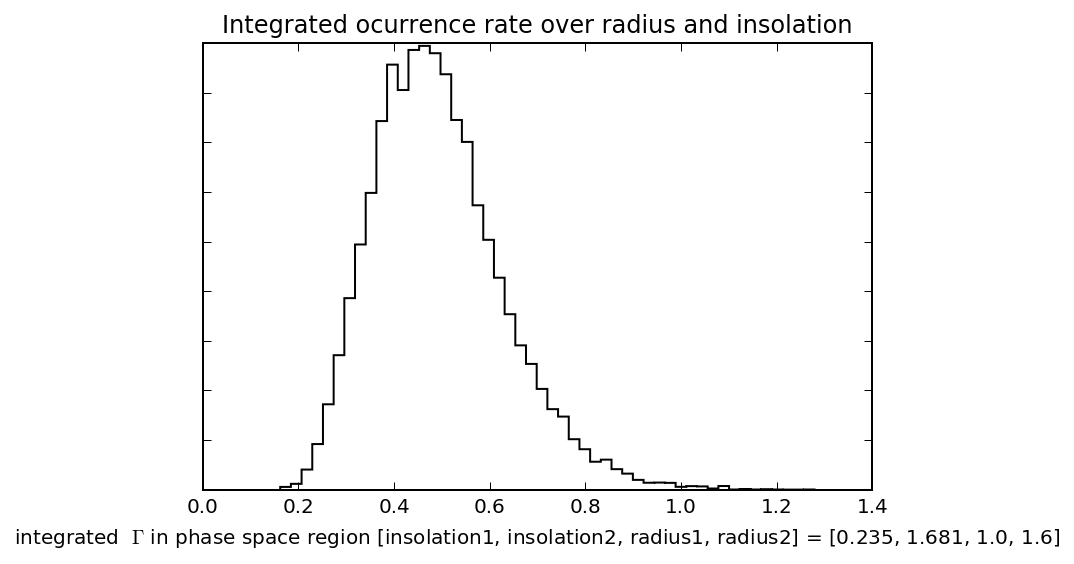

In [25]:
#%%=========================================================
# Integrate the planet density over a given range in insolation and radius
#   to get the exoplanet occurrence rate predicted by the power law in that region
def integrated_gamma(theta,insolation1,insolation2,radius1,radius2):
    lnf0, beta, alpha = theta
    
    # Phase Space Boundaries for our model
    insol_rng = (0.2, 20)
    radius_rng = (0.75, 2.5)
    
    # Compute exoplanet occurrence rate integrated over chosen region of [ insolation , radius] phase space
    integral_over_insolation = (insolation2**(beta + 1) - insolation1**(beta + 1))/(insol_rng[1]**(beta + 1) - insol_rng[0]**(beta + 1))
    integral_over_radius = (radius2**(alpha + 1) - radius1**(alpha + 1))/(radius_rng[1]**(alpha + 1) - radius_rng[0]**(alpha + 1))
    eta = integral_over_insolation*integral_over_radius*np.exp(lnf0)
    
    return eta
    

#%% Compute and plot the posterior PDF for the exoplanet occurence rate in a 
#   desired region of period, radius phase space

# Initialize   
int_gamma_samples = np.empty(len(sampler.flatchain))

# !!!!! Choose insolation limits according to stellar type

# Select G dwarfs
# insolation1 = 0.295
# insolation2 = 1.824

# Select K dwarfs
insolation1 = 0.235
insolation2 = 1.681

# Select M dwarfs
# insolation1 = 0.205
# insolation2 = 1.514

# !!!!! Choose radius limits
radius1 = 1.0
radius2 = 1.6

for i, theta in enumerate(sampler.flatchain):
    int_gamma_samples[i] = integrated_gamma(theta,insolation1,insolation2,radius1,radius2)

# print result for this phase space region
print("16, 50, 84 percentile range for integrated gamma = {0} ".format(np.percentile(int_gamma_samples,[16,50,84])))

             
# Plot the posterior of int gamma_samples over selected planet radius and period range             
pl.hist(int_gamma_samples, 50, histtype="step", color="k")
pl.gca().set_yticklabels([])
pl.title("Integrated ocurrence rate over radius and insolation")
pl.xlabel(r"integrated  $\Gamma$ in phase space region [insolation1, insolation2, radius1, radius2] = {0}".format([insolation1,insolation2,radius1,radius2]));
# pl.xlabel(r"$\log_{10}\Gamma_\oplus = \left. \log_{10}\mathrm{d}N / \mathrm{d}\ln P \, \mathrm{d}\ln R_p \right |_\oplus$");
pl.xticks


In [78]:
import pystan
import numpy as np

#%%===============================================================================================
# Pre-compute some values to be used in the Stan model

# Column names for RMS CDPP
cdpp_cols = [k for k in stlr.keys() if k.startswith("rrmscdpp")]

nPulseDuration = len(cdpp_cols)

# Values for the 14 pulse durations derived from column names
# cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)

# Values of RMS CDPP corresponding the the 14 pulse durations
cdpp_obs = np.array(star[cdpp_cols], dtype=float)

# Column names for the 14 MES thresholds
mesthres_cols = [k for k in stlr.keys() if k.startswith("mesthres")]

# Values for the 14 pulse durations derived from the column names
pulse_durations_obs = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],dtype=float) 

nPulses = len(pulse_durations_obs)
print(nPulses)
# MES threshold values corresponding to the 14 pulse durations
mesthres_obs = np.array(star[mesthres_cols],dtype=float)
                        
# mest <- np.interp(tau, pulse_durations_obs, mesthres_obs, dtype=float)
# x <- mes - 4.1 - (mest - 7.1);

# Insolation and planet radius grids
rp2 = np.linspace(rp_rng[0], rp_rng[1], 61)
nRadiusGrid = len(rp2)

insolation_rng = (0.2, 22)
insolation = np.linspace(insolation_rng[0], insolation_rng[1], 57)
nInsolationGrid = len(insolation)

# Make 2D meshgrids
insolation_grid, rp_grid2 = np.meshgrid(insolation, rp2, indexing="ij")

# 2D grid of insolation-radius phase space bin volumes
vol = np.diff(insolation_grid, axis=0)[:, :-1] * np.diff(rp_grid2, axis=1)[:-1, :]
volShape = list(vol.shape)

# Stellar parameters for the current star
teffStar = star.teff
teffSun = 5777
rStar = star.radius
mStar = star.mass
    
# Insolation and radius for planets in catalog
# koi_periods = np.array(kois.koi_period)
koi_insolation = np.array(kois.koi_insol)
koi_rps = np.array(kois.koi_prad)
nKois = len(koi_rps)



stan_model = """

functions {


// !!!!!TBD clean up all the unnecessary 'operator' notation

int intFloor(int leftStart, int rightStart, real iReal) {
  // This is absurd. Use bisection algorithm to find int floor.
  int left;
  int right;

  left <- leftStart;
  right <- rightStart;

  while((left + 1) < right) {
    int mid;
    print("left, right, mid, i, ", left, ", ", right, ", ", mid, ", ", iReal);
    mid <- left + (right - left) / 2;
    if(iReal < mid) {
      right <- mid;
    }
    else {
      left <- mid;
    }
  }
  return left;
}

// Interpolate arr using a non-integral index i
// Note: 1 <= i <= length(arr)
real interpolateLinear(real[] arr, real i) {
  int iLeft;
  real valLeft;
  int iRight;
  real valRight;

  print("interpolating ", i);

  // Get i, value at left. If exact time match, then return value.
  iLeft <- intFloor(1, size(arr), i);
  valLeft <- arr[iLeft];
  if(iLeft == i) {
    return valLeft;
  }

  // Get i, value at right.
  iRight <- iLeft + 1;
  valRight <- arr[iRight];

  // Linearly interpolate between values at left and right.
  return valLeft + (valRight - valLeft) * (i - iLeft);
}

real get_duration(real period, real aor, real e){
/*
    Equation (1) from Burke et al. This estimates the transit
    duration in the same units as the input period. There is a
    typo in the paper (24/4 = 6 != 4).
    
    :param period: the period in any units of your choosing
    :param aor:    the dimensionless semi-major axis (scaled
                  by the stellar radius)
    :param e:      the eccentricity of the orbit
*/

    return 0.25 * period * sqrt(1 - exp(2)) / aor;
}
        
real get_a(real period, real mstar) {
/*
   Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
   
    
*/
    real pi;
    pi <- 3.14159265359;
    return ((2945.4625385377644/(4*pi*pi))*period*period*mstar) ^ (1.0/3.0);
}

real get_delta(real k) {
/*
    Estimate the approximate expected transit depth as a function
    of radius ratio. There might be a typo here. In the paper it
    uses c + s*k but in the public code, it is c - s*k:
    https://github.com/christopherburke/KeplerPORTs
    
    :param k: the dimensionless radius ratio between the planet and
              the star
    
*/ 
    real c;
    real s;
    real delta_max;
    
    c <- 1.0874; 
    s <- 1.0187;
    delta_max <- k*k * (c + s*k);
    
/*  # !!!!! For Q1-Q16 (9.1 pipeline) DFM used a multiplier 0f 0.84 instead of 1.0 in the equation below
    # return 0.84*delta_max
    
    # !!!!! for Q1-Q17 DR24 (9.2 pipeline), use a multiplier of 1 
*/
    return 1.0* delta_max;
}



real get_mes(real nPulses, real star_radius, real star_data_span, real star_duty_cycle, real period, real rp, real tau, real[] pulse_durations_obs, real[] cdpp_obs) {

/*
    Estimate the multiple event statistic value for a transit.
    
    :param star_radius:   stellar properties 
    :param star_dataspan:   stellar properties
    :param star_dutycycle:   stellar properties

    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param tau:    the transit duration in hours
    :param sigma:  the rms cdpp in ppm
    
*/    

//     Interpolate to the RMS CDPP corresponding to the transit duration.
    // Fractional index for interpolation functions.
    real frac_index;
    frac_index <- ((tau - pulse_durations_obs[1])/(pulse_durations_obs[14] - pulse_durations_obs[1])) * nPulses;
    // Interpolate MES threshold corresponding to transit duration
    real sigma;
    sigma <- interpolateLinear( cdpp_obs, frac_index );


// Compute the radius ratio and estimate the S/N. $$$$$$$ (sub in constant)
    real re;
    real k;
    real snr;
    
    re <- 0.009171;
    k <- rp * re / star_radius;
    snr <- get_delta(k) * 1e6 / sigma;
    
// Scale by the estimated number of observed transits.
    
    real ntrn;
    
    ntrn <- star_dataspan * star_dutycycle / period ;
    return snr * sqrt(ntrn) ;


}



real get_pdet(real aor, real period, real rp, real e, real[] pulse_durations_obs, real[] mesthres_obs) {

/*
    Equation (5) from Burke et al. Estimate the detection efficiency
    for a transit.
    
    :param star:   a pandas row giving the stellar properties !!!!! not needed
   
    :param aor:    the dimensionless semi-major axis (scaled
                   by the stellar radius)
    :param period: the period in days
    :param rp:     the planet radius in Earth radii
    :param e:      the eccentricity
    :param pulse_durations_obs: a vector of 14 trial pulse durations 
    :param mesthres_obs: a vector of 14 MES thresholds corresponding to the 14 trial pulse durations   

    
*/

    // tau is the transit duration
    real tau;
    tau <- get_duration(period, aor, e) * 24.
    
    // mes is the Multiple Event Statistic corresponding to this signal; it is like SNR 
    real mes;
    mes <- get_mes(star_radius, star_data_span, star_duty_cycle, period, rp, tau, pulse_durations_obs, cdpp_obs );
    
    // Fractional index for interpolation functions.
    real frac_index;
    frac_index = ((tau - pulse_durations_obs[0])/(pulse_durations_obs[len(pulse_durations_obs)-1] - pulse_durations_obs[0])) * len(pulse_durations_obs);
    
    // Interpolate MES threshold corresponding to transit duration
    real mest;
    mest <- interpolateLinear( mesthres_obs, frac_index );
    
    // Argument for the gamma CDF model
    real x;
    x <- mes - 4.1 - (mest - 7.1);
    
/*    # !!!!! DFM originally used no multiplier in the equation below;
      # The multiplier of 0.78442 must be a 'plateau factor' from Jessie, for 9.2
      # for the 9.2 Q1-Q17 DR24 data, provided by Jessie
*/
    return 0.78442*gamma_cdf(x,103.0113,0.10583);
}


real get_pwin(real star_dataspan, real star_dutycycle, real period) {
/*
    Equation (6) from Burke et al. Estimates the window function
    using a binomial distribution.
    
    :param star:   a pandas row giving the stellar properties
    :param period: the period in days
    
*/  
    
    real M;
    real f;
    real omf;
    real pw;
    real msk;
    
    M <- star_dataspan / period;
    f <- star_dutycycle;
    omf <- 1.0 - f;
    pw <- 1 - omf**M - M*f*omf**(M-1) - 0.5*M*(M-1)*f*f*omf**(M-2);
    msk <- (pw >= 0.0) * (M >= 2.0)
    return pw * msk;

    
}

real get_pgeom(real aor, real e) {
/*
    The geometric transit probability.
    
    See e.g. Kipping (2014) for the eccentricity factor
    http://arxiv.org/abs/1408.1393
    
    :param aor: the dimensionless semi-major axis (scaled
                by the stellar radius)
    :param e:   the orbital eccentricity

*/    
    return 1. / (aor * (1 - e*e)) * (operator>(aor,1.0));
}

real get_completeness(real mStar, real rStar, real period, real rp, real e, real star_dataspan, real star_dutycycle) {

/*
    A helper function to combine all the completeness effects.
    
    :param star:      a pandas row giving the stellar properties !!!!! don't need
    :param mStar:     mass of star in solar units
    :param rStar:     radius of star in solar units
    :param period:    the period in days                 1D grid
    :param rp:        the planet radius in Earth radii   1D grid
    :param e:         the orbital eccentricity
    :param with_geom: include the geometric transit probability? !!!!! don't need
    :param star_dataspan:     length of observation data set in days
    :param star_dutycycle:    fraction of dataspan with valid data
    
*/  
    real aor;
    real pdet; 
    real pwin;
    real pgeom;
    
    aor <- operator/( get_a(period, mStar) , rStar );
    pdet <- get_pdet(aor, period, rp, e, pulse_durations_obs, mesthres_obs);
    pwin <- get_pwin(star_dataspan, star_dutycycle, period);
    pgeom <- get_pgeom(aor, e);
    return operator*( operator*( pdet , pwin ) , pgeom );
    
    
    

}   
    
real get_completeness_from_insolation(real teffStar, real teffSun, real rStar, real mStar, real[ , ] insolation_grid, real[ , ] rp_grid2, real e) {
/*
    :param teffStar:
    :param teffSun:
    :param rStar:
    :param mStar:
    :param insolation_grid:
    :param rp_grid2:
    :param e:
*/  
    real insolation;
    real period_grid;
    real completeness; 
    
    insolation <- insolation_grid;
    period_grid <- get_period_from_insolation( teffStar, teffSun, rStar, mStar, insolation );
    completeness <- get_completeness(mStar, rStar, period_grid, rp_grid2, e, star_dataspan, star_dutycycle);
    return completeness;
}    


real get_insolation_from_period( real teffStar , real teffSun, real rStar, real mStar, real period ) {

/*
     :param teffStar:
     :param teffSun:
     :param rStar:
     :param mStar:
     :param period:

*/
    
    
      real aPlanet;
      real insolation;
      
//    Semimajor axis of planet in AU

      // aPlanet = mStar^(1.0/3.0) * (period/365.25)^(2.0/3.0); 
      
      aPlanet <- operator*(operator^(mStar,operator/(1.0/3.0)),operator^(operator/(period/365.25),operator/(2.0/3.0)));
    
//    Insolation

      // insolation = (teffStar/teffSun)^4*(rStar/1)^2*(1/aPlanet)^2;
      
      insolation <- operator*(operator^(operator/(teffStar,teffSun),4),operator*(operator^(rStar,2),operator^(operator/(1,aPlanet),2)));
    
      return insolation;
}

real get_period_from_insolation( real teffStar , real teffSun, real rStar, real mStar, real [ , ] insolation ) {
/*  
     :param teffStar:
     :param teffSun:
     :param rStar:
     :param mStar:
     :param insolation:

      Get semimajor axis from star properties and insolation, using
      insolation <- ( teffStar / teffSun )^4 * ( rStar / 1)^2 * ( 1 / aPlanet )^2
      
      Get orbit period in days from semimajor axis of planet in AU and start properties, using
      aPlanet <- mStar^(1.0/3.0) * (period/365.25)^(2.0/3.0)
*/
      
      real aPlanet;
      real period;
      
      //aPlanet <- ( ( teffStar / teffSun )^4 * ( rStar / 1)^2 / insolation )^(0.5);
      
      aPlanet <- operator*( operator^( operator/(teffStar,teffSun) , 4),operator^( operator/(operator^(rStar,2),insolation) ,0.5) );
    
      //period <- 365.25 * ( aPlanet/( mStar^(1.0/3.0) ) )^(3.0/2.0);
      
      period <- operator*( 365.25, operator^( operator/( aPlanet, operator^( mStar,operator/(1.0,3.0) ) ) ,operator/( 3.0, 2.0 ) ) );
    
      return period;
}

real population_model_insolation(real lnf0, real alpha, real beta, real[ , ] Insol, real[ , ] Rp) {

/* Population inference with an independent power law model
   Using modified code above that computes 
   completeness in the phase space of [ insolation , planet radius ], 

   A double power law model for the population.

   :param f0: normalization, 
   :param beta: exponent of insolation power law,
   :param alpha: exponent of radius power law
   :param Insol 2D meshgrid
   :param Rp    2D meshgrid
   
   
*/    
    for (i in 1:NdataRp) 
        for (j in 1:NdataInsol) {
            v[i,j] <- exp(lnf0) * (alpha+1)(beta+1)Rp[i,j]^alpha * Insol[i,j]^beta / ((Rpmax^(alpha+1)-Rpmin^(alpha+1)*(insolmax^(beta+1)-insolmin^(beta+1)));
        }
}

real population_model_insolation1D(real lnf0, real alpha, real beta, real[] Insol, real[] Rp) {

/* Population inference with an independent power law model
   Using modified code above that computes 
   completeness in the phase space of [ insolation , planet radius ], 
   
   This modified version takes 1D lists of Insol and Rp as inputs

   A double power law model for the population.

   :param f0: normalization, 
   :param beta: exponent of insolation power law,
   :param alpha: exponent of radius power law
   :param Insol 2D meshgrid
   :param Rp    2D meshgrid
   
   
*/    
    for (i in 1:NdataRp) 
        for (j in 1:NdataInsol) {
            v[i,j] <- exp(lnf0) * (alpha+1)(beta+1)Rp[i,j]^alpha * Insol[i,j]^beta / ((Rpmax^(alpha+1)-Rpmin^(alpha+1)*(insolmax^(beta+1)-insolmin^(beta+1)));
        }
}

real lnlike(real alpha, real beta, real f0, real[] vol, real[ , ] insolation_grid, real[ , ] rp_grid2, real[ , ] new_completeness, real[] koi_insolation, real[] koi_rps) {

/* log likelihood function

    :param alpha:
    :param beta:
    :param f0:
    :param vol:
    :param insolation_grid:
    :param rp_grid2:
    :param new_completeness:
    :param koi_insolation:
    :param koi_rps:
*/

    pop <- operator.*(population_model_insolation(f0, alpha, beta, insolation_grid, rp_grid2) , new_completeness);
    
    // !!!!! Figured out the proper syntax for the line below:
    // !!!!! note that matrix indices start with 1 in Stan
    // pop <- 0.5*(pop[:-1, :-1] + pop[1:, 1:]); 
    
    nRows <- rows(pop);
    nCols <- cols(pop);
    pop1 <- block(pop, 1, 1, operator-(nRows, 1), operator-(nCols, 1) ;
    pop2 <- block(pop, 2, 2, operator-(nRows, 1), operator-(nCols, 1) ;
    pop <- operator*( 0.5, operator+( pop1, pop2 ) );
    
    norm <- sum(operator.*(pop,vol));
    
    ll <- operator-( sum ( log( population_model_insolation1D(f0, alpha, beta, koi_insolation, koi_rps) ) ) , norm );
    // problem: koi_insolation and koi_rps are 1D grids, so we need another copy of population_model_insolation 
    // that takes 1D lists of koi_insolation and koi_rps as inputs
    
    return if_else( is_inf(ll) || is_nan(ll) , negative_infinity(), ll );

}

} # end function block

data {

// Declare precomputed variables as data

int<lower=1> nPulses;

int<lower=1> nRadiusGrid;

int<lower=1> nInsolationGrid;

real<lower=0> cdpp_obs[nPulses];

real<lower=0> mesthres_obs[nPulses];

real<lower=0> pulse_durations_obs[nPulses]

real insolation_rng[2];

real rp_rng[2]; 

real<lower=0> insolation[nInsolationGrid];

real<lower=0> rp2[nRadiusGrid];

real<lower=0> insolation_grid[nRadiusGrid,nInsolationGrid];

real<lower=0> rp_grid2[nRadiusGrid,nInsolationGrid];

real<lower=0> vol[nRadiusGrid-1,nInsolationGrid-1];

real<lower=0> teffStar;

real<lower=0> teffSun;

real<lower=0> rStar;

real<lower=0> mStar;

real<lower=0> koi_insolation[nKois];

real<lower=0> koi_rps[nKois];

real<lower=0> new_completeness[nRadiusGrid-1,nInsolationGrid-1];

}


parameters {

real<lower=-5,upper=5> alpha; 
real<lower=-5,upper=5> beta;
real<lower=-5,upper=5> lnf0;

}

model {

    
    increment_log_prob(lnlike(alpha, beta, f0, vol, insolation_grid, rp_grid2, new_completeness, koi_insolation, koi_rps));
    alpha ~ uniform(-5,5);
    beta ~ uniform(-5,5);
    lnf0 ~ uniform(-5,5);
}


"""

data = {'nPulses':nPulses , 'nRadiusGrid':nRadiusGrid, 'nRadiusGrid':nRadiusGrid, 
        'nInsolationGrid':nInsolationGrid, 'cdpp_obs':cdpp_obs, 'mesthres_obs':mesthres_obs,
        'pulse_durations_obs':pulse_durations_obs, 'insolation_rng':insolation_rng, 'rp_rng':rp_rng,
        'insolation':insolation, 'rp2':rp2, 'insolation_grid':insolation_grid, 'rp_grid2':rp_grid2, 
        'vol':vol, 'teffStar':teffStar,'teffSun':teffSun, 'rStar':rStar, 'mStar':mStar, 'koi_insolation':koi_insolation,
        'koi_insolation':koi_insolation, 'koi_rps':koi_rps, 'new_completeness':new_completeness}

fit = pystan.stan(model_code=stan_model, data=data, iter=10, chains=5, n_jobs=-1);




14


ValueError: Failed to parse Stan model 'anon_model_1f0497888067fd0609022f18cd4ea5e5'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:

Warning: integer division implicitly rounds to integer. Found int division: (right - left) / 2
 Positive values rounded down, negative values rounded up or down in platform-dependent way.
variable "real" does not exist.

ERROR at line 134

 132:        frac_index <- ((tau - pulse_durations_obs[1])/(pulse_durations_obs[14] - pulse_durations_obs[1])) * nPulses;
 133:        // Interpolate MES threshold corresponding to transit duration
 134:        real sigma;
                 ^
 135:        sigma <- interpolateLinear( cdpp_obs, frac_index );

